In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, tensorflow as tf
import sys, time

2024-03-25 15:10:11.677306: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 15:10:11.677335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 15:10:11.678491: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-25 15:10:11.684571: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-25 15:10:12.525419: W tensorflow/compiler/tf2

In [2]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from timeVAE.vae_dense_model import VariationalAutoencoderDense as VAE_Dense
from timeVAE.vae_conv_model import VariationalAutoencoderConv as VAE_Conv
from timeVAE.vae_conv_I_model import VariationalAutoencoderConvInterpretable as TimeVAE
from timeVAE import utils
from sklearn.preprocessing import MinMaxScaler

In [48]:
base_data_train, base_data_test = np.load('../../data/training_data/training_data_1month.npy', allow_pickle=True)
base_data_train, base_data_test = base_data_train[:,:,[1,2]], base_data_test[:,:,[1,2]] # 0,3 = th vs air; 1,2 = el vs sky
print(base_data_train.shape, base_data_test.shape)

(108, 730, 2) (12, 730, 2)


In [33]:
#print(base_data_train, base_data_test)

In [49]:
import tensorflow as tf

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

<h3> Scale data </h3>

In [50]:
from sklearn.preprocessing import MinMaxScaler

# Important to store each of the scalers we use for inverse transforming later
scalers = {var_name: MinMaxScaler(feature_range=(-1,1)) for var_name in ['G.air.T', 'G.E_th_I', 'month']}

temp_var, energy_var = base_data_train[:,:,0], base_data_train[:,:,1]
temp_var_test, energy_var_test = base_data_test[:,:,0], base_data_test[:,:,1]
#indicator_var, indicator_var_test = base_data_train[:,:,2], base_data_test[:,:,2]

temp_var = scalers['G.air.T'].fit_transform(temp_var)
energy_var = scalers['G.E_th_I'].fit_transform(energy_var)
#indicator_var = scalers['month'].fit_transform(indicator_var)

temp_var_test = scalers['G.air.T'].fit_transform(temp_var_test)
energy_var_test = scalers['G.E_th_I'].fit_transform(energy_var_test)
#indicator_var_test = scalers['month'].fit_transform(indicator_var_test)

scaled_data_train, scaled_data_test = np.stack((temp_var, energy_var), axis=-1), np.stack((temp_var_test, energy_var_test), axis=-1)
print(scaled_data_train.shape, scaled_data_test.shape)

(108, 730, 2) (12, 730, 2)


<h3> Build VAE </h3>

In [51]:
LATENT_DIM    = 3
LEARNING_RATE = 0.001
EPOCHS        = 1000
BATCH_SIZE    = 4


In [52]:
seq_len = base_data_train.shape[1]
feat_dim = base_data_train.shape[2]

hidden_layer_sizes = [64,128,64]

model = TimeVAE(seq_len=seq_len, 
                feat_dim=feat_dim, 
                latent_dim=LATENT_DIM, 
                hidden_layer_sizes=hidden_layer_sizes,
                use_scaler=False)

In [53]:
model.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 730, 2)]             0         []                            
                                                                                                  
 enc_conv_0 (Conv1D)         (None, 365, 64)              448       ['encoder_input[0][0]']       
                                                                                                  
 enc_conv_1 (Conv1D)         (None, 183, 128)             24704     ['enc_conv_0[0][0]']          
                                                                                                  
 enc_conv_2 (Conv1D)         (None, 92, 64)               24640     ['enc_conv_1[0][0]']          
                                                                                            

In [54]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='reconstruction_loss')

<h3> Run VAE </h3>

In [55]:
early_stop = EarlyStopping(monitor='reconstruction_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr  = ReduceLROnPlateau(monitor='reconstruction_loss', factor=0.5, patience=5, verbose=1)

model.fit(scaled_data_train,
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
        shuffle = True,
        callbacks = [early_stop, reduce_lr],
        verbose = 1)

Epoch 1/1000
27/27 [==============================] - 2s 16ms/step - loss: 13216.0414 - reconstruction_loss: 3562.0452 - kl_loss: 103.5981 - lr: 0.0010
Epoch 2/1000
27/27 [==============================] - 0s 15ms/step - loss: 8213.2684 - reconstruction_loss: 2801.2751 - kl_loss: 141.3522 - lr: 0.0010
Epoch 3/1000
27/27 [==============================] - 0s 15ms/step - loss: 7875.4075 - reconstruction_loss: 2589.3069 - kl_loss: 92.9459 - lr: 0.0010
Epoch 4/1000
27/27 [==============================] - 0s 16ms/step - loss: 8084.0286 - reconstruction_loss: 2525.5535 - kl_loss: 62.3515 - lr: 0.0010
Epoch 5/1000
27/27 [==============================] - 0s 17ms/step - loss: 7347.2958 - reconstruction_loss: 2494.9280 - kl_loss: 62.9384 - lr: 0.0010
Epoch 6/1000
27/27 [==============================] - 0s 16ms/step - loss: 7434.6645 - reconstruction_loss: 2483.9797 - kl_loss: 52.2506 - lr: 0.0010
Epoch 7/1000
27/27 [==============================] - 0s 16ms/step - loss: 7540.1523 - reconstruc

27/27 [==============================] - 0s 16ms/step - loss: 3361.6305 - reconstruction_loss: 1090.0054 - kl_loss: 84.5739 - lr: 0.0010
Epoch 56/1000
27/27 [==============================] - 0s 16ms/step - loss: 3322.5692 - reconstruction_loss: 1066.0081 - kl_loss: 85.9200 - lr: 0.0010
Epoch 57/1000
27/27 [==============================] - 0s 15ms/step - loss: 2705.8077 - reconstruction_loss: 920.1423 - kl_loss: 84.3992 - lr: 0.0010
Epoch 58/1000
27/27 [==============================] - 0s 16ms/step - loss: 2778.6371 - reconstruction_loss: 899.4944 - kl_loss: 87.7063 - lr: 0.0010
Epoch 59/1000
27/27 [==============================] - 0s 16ms/step - loss: 2897.9357 - reconstruction_loss: 895.1249 - kl_loss: 86.9083 - lr: 0.0010
Epoch 60/1000
27/27 [==============================] - 0s 16ms/step - loss: 2402.8315 - reconstruction_loss: 785.9218 - kl_loss: 85.7675 - lr: 0.0010
Epoch 61/1000
27/27 [==============================] - 0s 16ms/step - loss: 2232.5655 - reconstruction_loss: 727

27/27 [==============================] - 0s 16ms/step - loss: 291.1192 - reconstruction_loss: 71.2433 - kl_loss: 77.5037 - lr: 5.0000e-04
Epoch 108/1000
27/27 [==============================] - 0s 15ms/step - loss: 288.1101 - reconstruction_loss: 67.4043 - kl_loss: 76.8170 - lr: 5.0000e-04
Epoch 109/1000
27/27 [==============================] - 0s 16ms/step - loss: 288.5262 - reconstruction_loss: 64.9509 - kl_loss: 76.2846 - lr: 5.0000e-04
Epoch 110/1000
27/27 [==============================] - 0s 15ms/step - loss: 255.7628 - reconstruction_loss: 66.8599 - kl_loss: 76.8173 - lr: 5.0000e-04
Epoch 111/1000
27/27 [==============================] - 0s 16ms/step - loss: 338.1073 - reconstruction_loss: 73.5883 - kl_loss: 77.0029 - lr: 5.0000e-04
Epoch 112/1000
27/27 [==============================] - 0s 17ms/step - loss: 266.9445 - reconstruction_loss: 66.9212 - kl_loss: 77.3984 - lr: 5.0000e-04
Epoch 113/1000
27/27 [==============================] - 0s 16ms/step - loss: 241.6375 - reconstru

27/27 [==============================] - 0s 16ms/step - loss: 107.0632 - reconstruction_loss: 11.1760 - kl_loss: 67.6437 - lr: 2.5000e-04
Epoch 160/1000
27/27 [==============================] - 0s 16ms/step - loss: 104.6718 - reconstruction_loss: 11.1226 - kl_loss: 67.2587 - lr: 2.5000e-04
Epoch 161/1000
27/27 [==============================] - 0s 17ms/step - loss: 96.4651 - reconstruction_loss: 11.0959 - kl_loss: 67.3402 - lr: 2.5000e-04
Epoch 162/1000
27/27 [==============================] - 0s 15ms/step - loss: 100.1809 - reconstruction_loss: 10.5507 - kl_loss: 67.2567 - lr: 2.5000e-04
Epoch 163/1000
27/27 [==============================] - 0s 16ms/step - loss: 104.6202 - reconstruction_loss: 10.0735 - kl_loss: 66.7383 - lr: 2.5000e-04
Epoch 164/1000
27/27 [==============================] - 0s 16ms/step - loss: 89.8474 - reconstruction_loss: 9.9716 - kl_loss: 66.7865 - lr: 2.5000e-04
Epoch 165/1000
27/27 [==============================] - 0s 16ms/step - loss: 88.6460 - reconstructio

27/27 [==============================] - 0s 18ms/step - loss: 72.1152 - reconstruction_loss: 3.6316 - kl_loss: 63.0527 - lr: 6.2500e-05
Epoch 211/1000
25/27 [==========================>...] - ETA: 0s - loss: 73.8256 - reconstruction_loss: 3.7707 - kl_loss: 63.4905
Epoch 211: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
27/27 [==============================] - 0s 15ms/step - loss: 73.8813 - reconstruction_loss: 3.7239 - kl_loss: 62.9795 - lr: 6.2500e-05
Epoch 212/1000
27/27 [==============================] - 0s 16ms/step - loss: 72.1154 - reconstruction_loss: 3.1173 - kl_loss: 62.7857 - lr: 3.1250e-05
Epoch 213/1000
27/27 [==============================] - 0s 15ms/step - loss: 71.8943 - reconstruction_loss: 3.1917 - kl_loss: 62.9341 - lr: 3.1250e-05
Epoch 214/1000
27/27 [==============================] - 0s 16ms/step - loss: 72.0518 - reconstruction_loss: 3.4557 - kl_loss: 62.8264 - lr: 3.1250e-05
Epoch 215/1000
27/27 [==============================] - 0s 16ms/step

[]

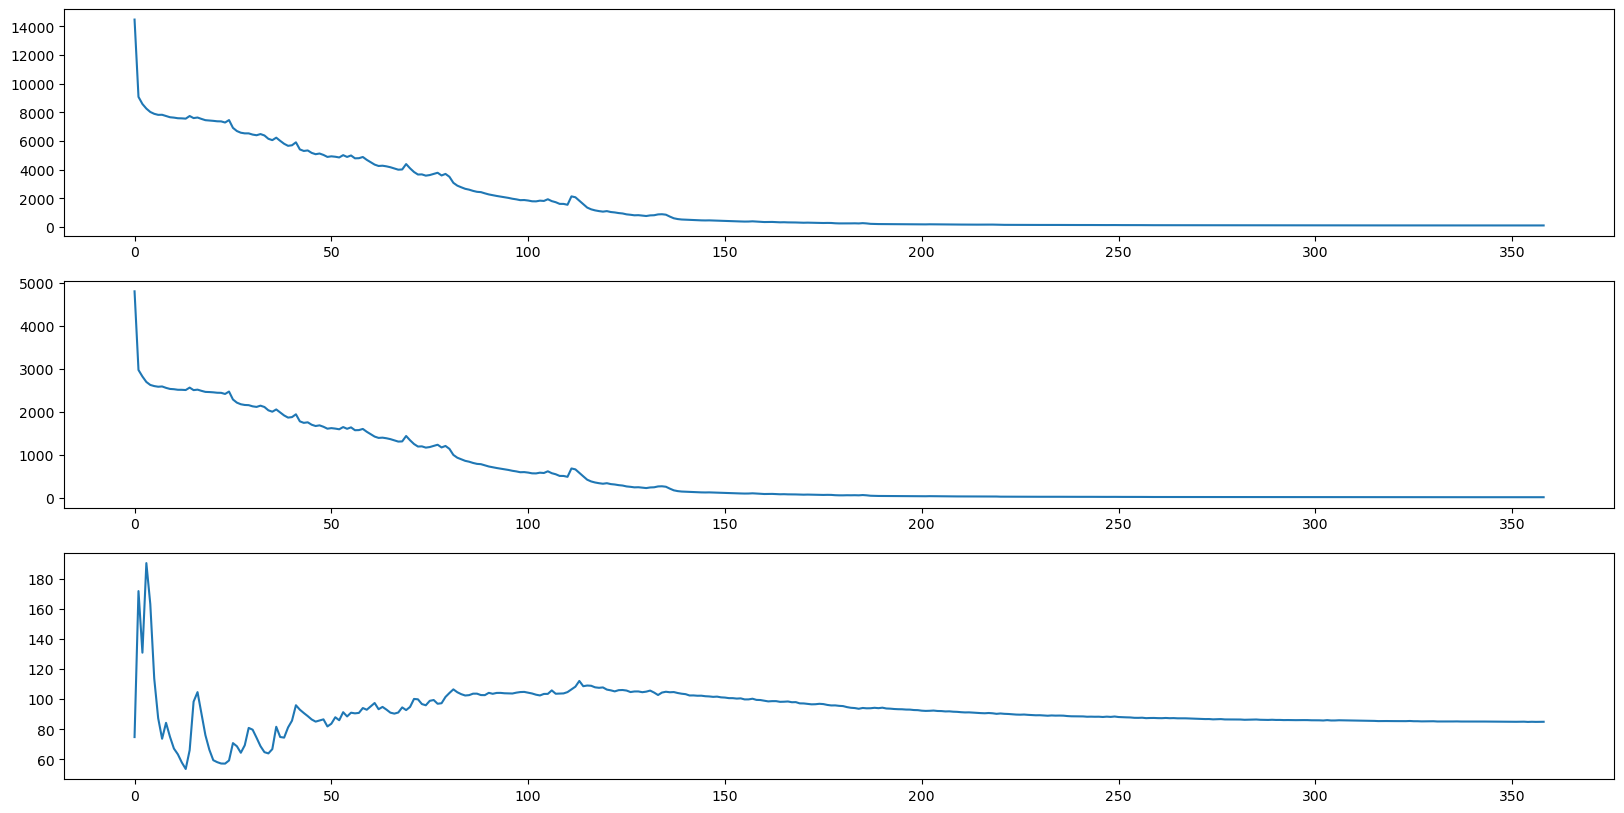

In [41]:
fig, ax = plt.subplots(3,1,figsize=(20,10))
ax[0].plot(model.history.history['loss'])
ax[1].plot(model.history.history['reconstruction_loss'])
ax[2].plot(model.history.history['kl_loss'])
plt.plot()

<h3> Generate synthetic samples </h3>

In [42]:
num_samples = 1000
generated_samples = model.get_prior_samples(num_samples=num_samples)
print(generated_samples.shape)

32/32 [==============================] - 2s 9ms/step
(1000, 730, 2)


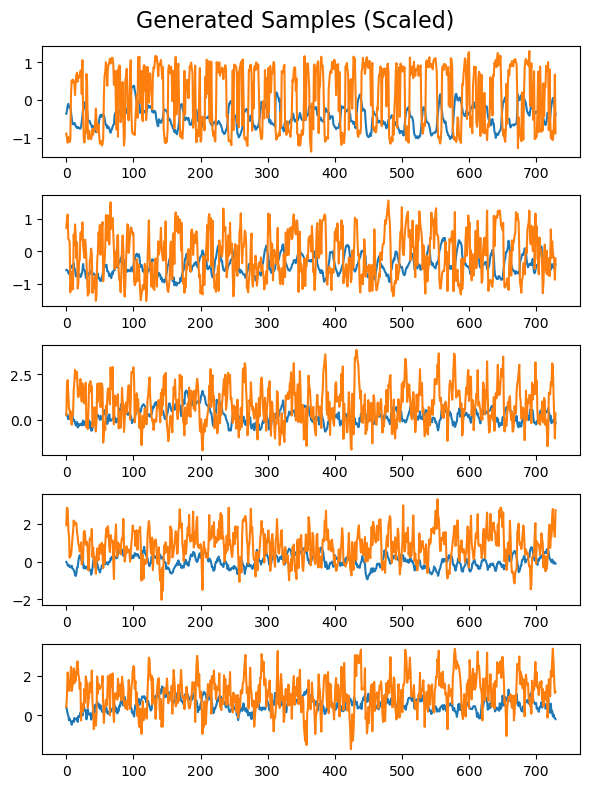

In [43]:
utils.plot_samples(generated_samples,n=5)

In [44]:
temp_var, energy_var = generated_samples[:,:,0], generated_samples[:,:,1]
temp_var, energy_var = scalers['G.air.T'].inverse_transform(temp_var), scalers['G.E_th_I'].inverse_transform(energy_var)

rescaled_samples = np.stack((temp_var, energy_var),axis=-1)

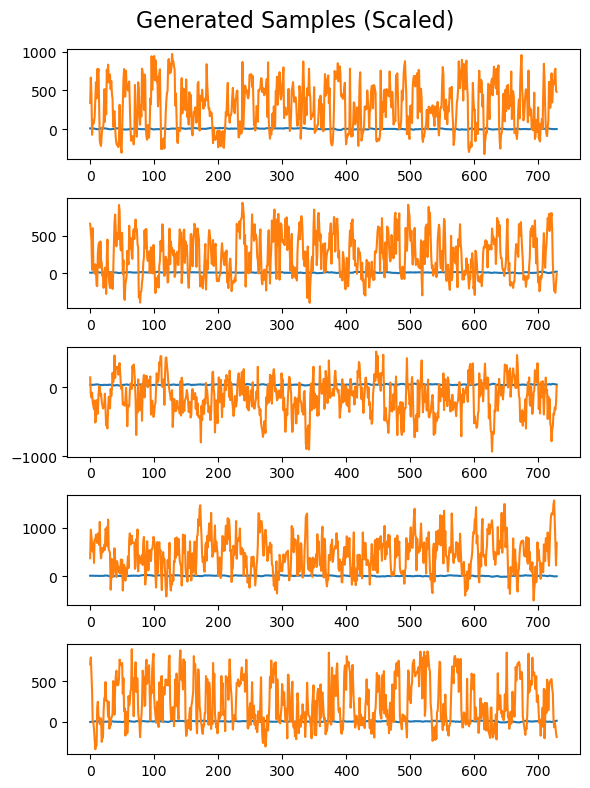

In [45]:
utils.plot_samples(rescaled_samples,n=5)

In [46]:
np.save('../../data/vae_synthetic_data/el_v_sky_generated_samples.npy', generated_samples)
np.save('../../data/vae_synthetic_data/el_v_sky_rescaled_samples.npy', rescaled_samples)

In [47]:
loss = pd.DataFrame(model.history.history)
loss.to_csv(f'../../data/models/model_history/el_v_sky_loss.csv')

<h3> Hyperparameter tuning </h3>

In [ ]:
latent_dims = [3, 5, 10, 15, 20, 25, 30, 50]
batch_sizes = [4, 8, 16, 20, 24, 32]
learning_rates = [0.001]

losses = []
sample_list = []

seq_len = base_data_train.shape[1]
feat_dim = base_data_train.shape[2]

hidden_layer_sizes = [64,128,64]

for lr in learning_rates:
    for l_dim in latent_dims:
        for b_size in batch_sizes:
            vae = TimeVAE(seq_len=seq_len, 
                    feat_dim=feat_dim, 
                    latent_dim=l_dim, 
                    hidden_layer_sizes=hidden_layer_sizes,
                    use_scaler=False)

            vae.compile(optimizer=Adam(learning_rate=lr), loss='reconstruction_loss')

            early_stop = EarlyStopping(monitor='reconstruction_loss', patience=10, verbose=1, restore_best_weights=True)
            reduce_lr  = ReduceLROnPlateau(monitor='reconstruction_loss', factor=0.5, patience=5, verbose=1)

            print(f'Latent dimension: {l_dim}, Batch size: {b_size}')
            vae.fit(scaled_data_train,
                    epochs = 1000,
                    batch_size = b_size,
                    shuffle = True,
                    callbacks = [early_stop, reduce_lr],
                    verbose = 1)

            loss = pd.DataFrame(vae.history.history)
            loss.to_csv(f'../data/tuning/tuning_3/lr{lr}l{l_dim}b{b_size}_hist.csv')
            losses.append(loss)

            samples = vae.get_prior_samples(num_samples=10000)
            np.save(f'../data/tuning/tuning_3/lr{lr}l{l_dim}b{b_size}_samples.npy', samples)
            sample_list.append(samples)

            samples_temp_var, samples_energy_var = samples[:,:,0], samples[:,:,1]
            samples_temp_var, samples_energy_var = scalers['G.air.T'].inverse_transform(samples_temp_var), \
                scalers['G.E_th_I'].inverse_transform(samples_energy_var)

            scaled_samples = np.stack((samples_temp_var, samples_energy_var), axis=-1)
            np.save(f'../data/tuning/tuning_3/lr{lr}l{l_dim}b{b_size}_scaled_samples.npy', scaled_samples)

Latent dimension: 3, Batch size: 4
Epoch 1/1000
27/27 [==============================] - 3s 24ms/step - loss: 13368.1260 - reconstruction_loss: 2412.4348 - kl_loss: 73.4008 - lr: 0.0010
Epoch 2/1000
27/27 [==============================] - 1s 25ms/step - loss: 3740.9109 - reconstruction_loss: 1113.2490 - kl_loss: 90.9818 - lr: 0.0010
Epoch 3/1000
27/27 [==============================] - 1s 24ms/step - loss: 3763.0036 - reconstruction_loss: 1092.0294 - kl_loss: 53.3346 - lr: 0.0010
Epoch 4/1000
27/27 [==============================] - 1s 23ms/step - loss: 3342.8540 - reconstruction_loss: 1098.2833 - kl_loss: 76.4034 - lr: 0.0010
Epoch 5/1000
27/27 [==============================] - 1s 24ms/step - loss: 3058.9711 - reconstruction_loss: 1000.1190 - kl_loss: 78.8366 - lr: 0.0010
Epoch 6/1000
27/27 [==============================] - 1s 24ms/step - loss: 2821.0000 - reconstruction_loss: 950.8398 - kl_loss: 51.8619 - lr: 0.0010
Epoch 7/1000
27/27 [==============================] - 1s 25ms/ste

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



7/7 [==============================] - 2s 40ms/step - loss: 58729.8047 - reconstruction_loss: 14484.4209 - kl_loss: 53.3626 - lr: 0.0010
Epoch 2/1000
7/7 [==============================] - 0s 35ms/step - loss: 20936.2415 - reconstruction_loss: 6229.9185 - kl_loss: 272.0567 - lr: 0.0010
Epoch 3/1000
7/7 [==============================] - 0s 35ms/step - loss: 16017.8950 - reconstruction_loss: 4891.1475 - kl_loss: 283.1635 - lr: 0.0010
Epoch 4/1000
7/7 [==============================] - 0s 36ms/step - loss: 14639.5193 - reconstruction_loss: 4530.7446 - kl_loss: 305.2105 - lr: 0.0010
Epoch 5/1000
7/7 [==============================] - 0s 35ms/step - loss: 12691.5258 - reconstruction_loss: 4301.5479 - kl_loss: 337.5237 - lr: 0.0010
Epoch 6/1000
7/7 [==============================] - 0s 35ms/step - loss: 13168.8569 - reconstruction_loss: 4176.6479 - kl_loss: 295.7127 - lr: 0.0010
Epoch 7/1000
7/7 [==============================] - 0s 35ms/step - loss: 13337.3400 - reconstruction_loss: 4110.8

In [154]:
model.get_prior_samples(num_samples=5).shape #vae.get_prior_samples(num_samples=5).shape

1/1 [==============================] - 0s 28ms/step


(5, 730, 2)

In [27]:
latent_dims = [3, 5, 10, 15, 20, 25, 30, 50]
batch_sizes = [4, 8, 16, 20, 24, 32]
min_loss = 1000

for l_dim in latent_dims:
    for b_size in batch_sizes:
        loss = pd.read_csv(f'../../data/trai/lr0.001l{l_dim}b{b_size}_hist.csv')
        if loss['kl_loss'].min() < min_loss:
            min_loss = loss['kl_loss'].min()
            print(f'{l_dim}, {b_size}: {loss["kl_loss"].min()}')

FileNotFoundError: [Errno 2] No such file or directory: '../data/tuning/tuning_3/lr0.001l3b4_hist.csv'

In [ ]:
for l_dim in latent_dims:
    for b_size in batch_sizes:
        loss = pd.read_csv(f'../data/tuning/tuning_3_el_v_sky/lr0.001l{l_dim}b{b_size}_hist.csv')
        print(f'{l_dim}, {b_size}: {loss["reconstruction_loss"].min()}, {np.round(loss["reconstruction_loss"].iloc[-1],4)}')

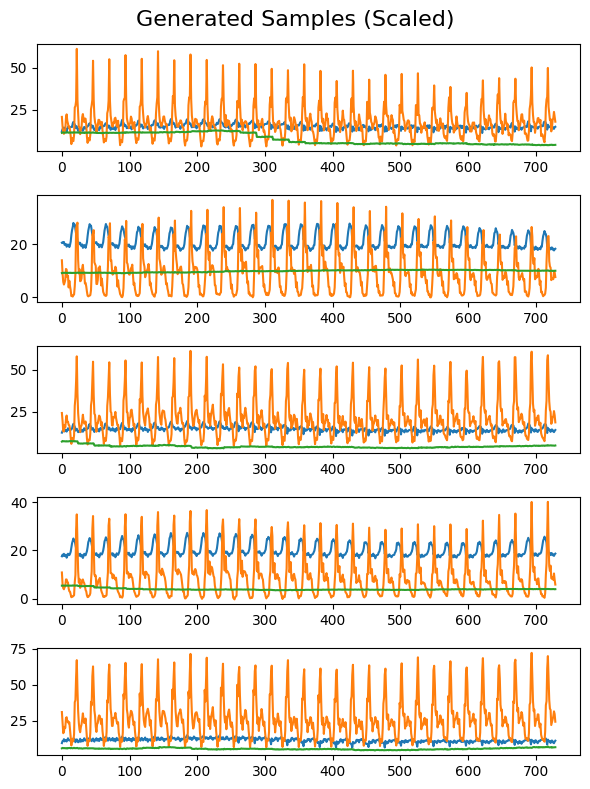

In [158]:
samples = np.load(f'../data/tuning/junkrun1/lr0.001l3b16_scaled_samples.npy')
utils.plot_samples(samples, n=5)

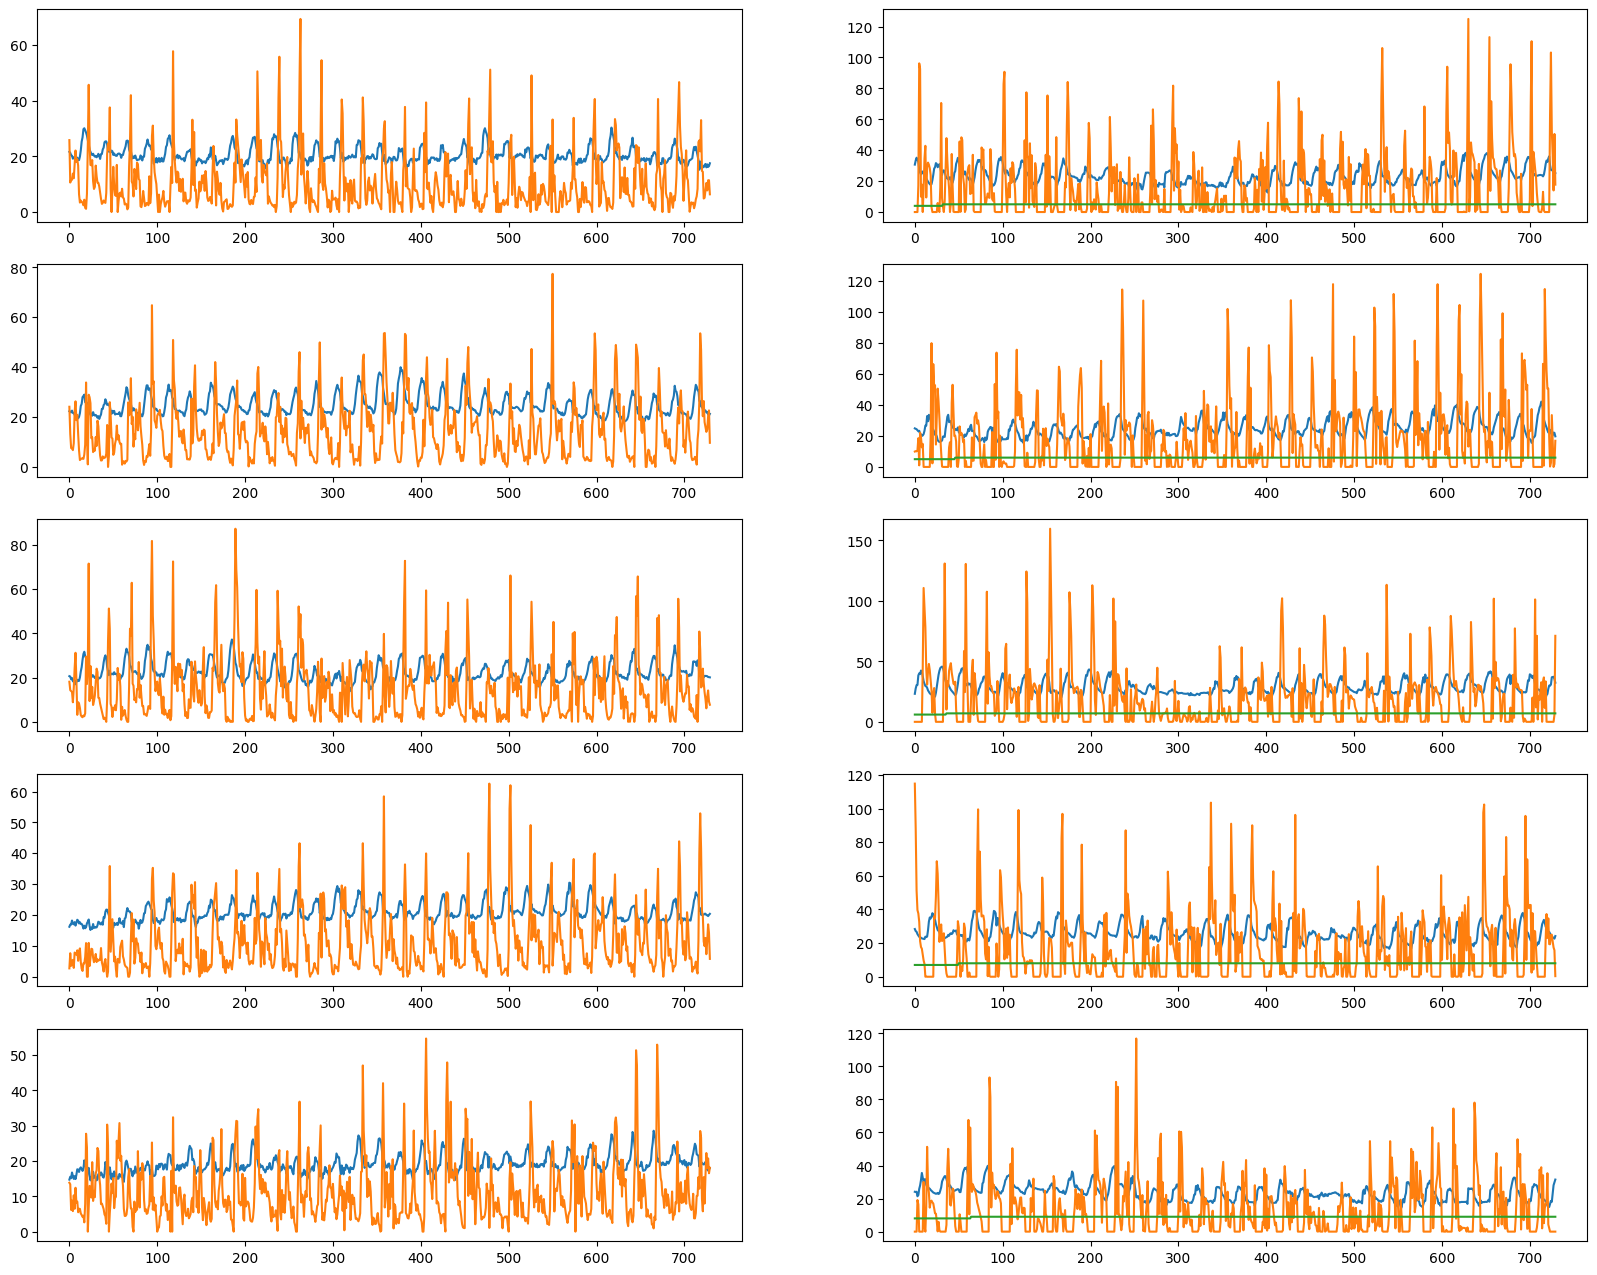

In [392]:
offset = 100
fig, ax = plt.subplots(5, 2, figsize=(20,16))
for i in range(5):
    ax[i,0].plot(scaled_sample[i+offset,:])
    ax[i,1].plot(base_data_train[i+offset,:])

Synthetic samples are starting to look a lot better. However negative energy values are impossible. To solve this we can simply truncate all values below 0, or we can shift the values up to be above 0. We can even combine the two approaches as below. (or we can ignore it and hope it doesn't affect evaluation)

In [114]:
scaled_sample = scaled_sample_list[0].copy()

sub_zero_vals = scaled_sample[:,:,1][scaled_sample[:,:,1] < 0]
sub_zero99 = np.percentile(sub_zero_vals, 20)

print(sub_zero99)
scaled_sample[:,:,1] += abs(sub_zero99)

-3.0234012603759766


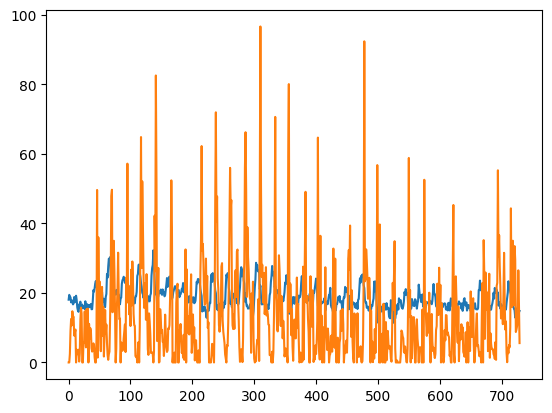

In [116]:
scaled_sample = np.where(scaled_sample < 0, 0, scaled_sample)
plt.plot(scaled_sample[0])

In [122]:
np.save('../data/th_v_air_sample.npy',scaled_sample)#_list[0])

<h3> Selecting the best model </h3>

3, 16:	1206.52490234375, 147.5886993408203
	1206.52490234375, 142.17529296875



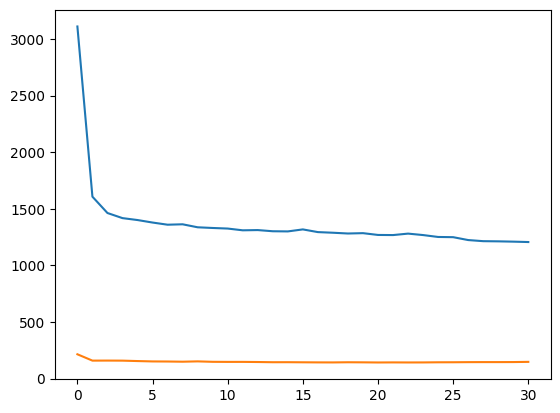

5, 16:	1082.133056640625, 214.4638519287109
	1082.133056640625, 197.25733947753903



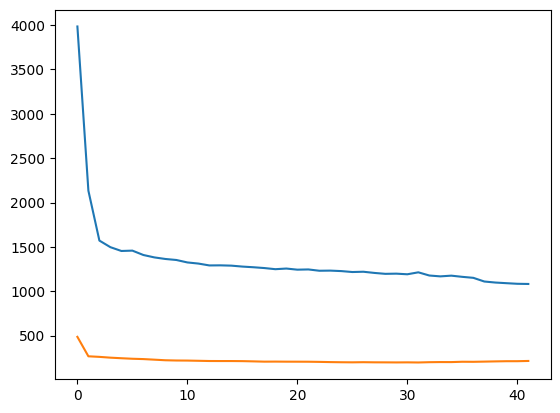

In [208]:
latent_dims = [3,5]
batch_sizes = [16]#,24,32]
min_loss = 1000

for l_dim in latent_dims:
    for b_size in batch_sizes:
        loss = pd.read_csv(f'../data/tuning/junkrun1/lr0.001l{l_dim}b{b_size}_hist.csv')
        print(f'{l_dim}, {b_size}:\t{loss["reconstruction_loss"].iloc[-1]}, {loss["kl_loss"].iloc[-1]}')
        
        print(f'\t{loss["reconstruction_loss"].min()}, {loss["kl_loss"].min()}\n')
        plt.plot(loss[["reconstruction_loss", "kl_loss"]])
        plt.show()

(1000, 730, 3) (1000, 730, 3)


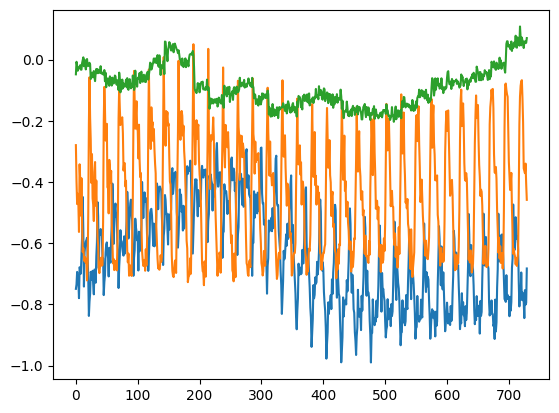

In [205]:
samples = np.load('../data/tuning/junkrun1/lr0.001l3b16_samples.npy')
scaled_samples = np.load('../data/tuning/junkrun1/lr0.001l3b16_scaled_samples.npy')
print(samples.shape, scaled_samples.shape)
plt.plot(samples[2,:])

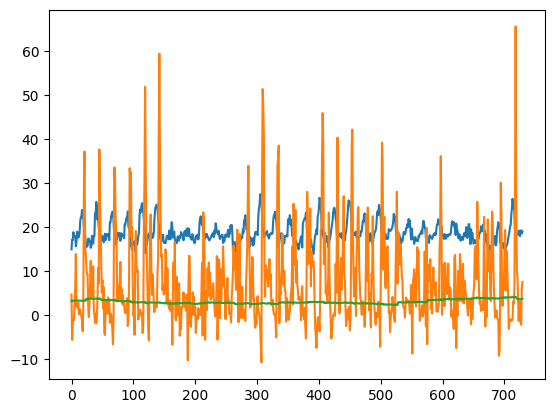

In [418]:
plt.plot(rescaled_samples[2,:])

In [378]:
reshaped_sample = scaled_samples.reshape(-1, 3)
print(pd.DataFrame(reshaped_sample, columns=['G.air.T', 'G.E_th_I', 'month']).describe())

             G.air.T       G.E_th_I          month
count  730000.000000  730000.000000  730000.000000
mean       19.788651      10.604332       6.386692
std         4.279791      10.048422       2.895654
min        -3.002542     -42.836674      -2.924322
25%        17.282743       3.230851       4.175731
50%        19.039019       8.354959       6.296662
75%        21.934312      14.714235       8.583144
max        39.231400      80.863464      15.535751


<h3> Create datasets for testing strategies </h3>

Must create:
 - Purely synthetic dataset
 - Synthetic runs into real data
 - Synthetic-Real blended dataset

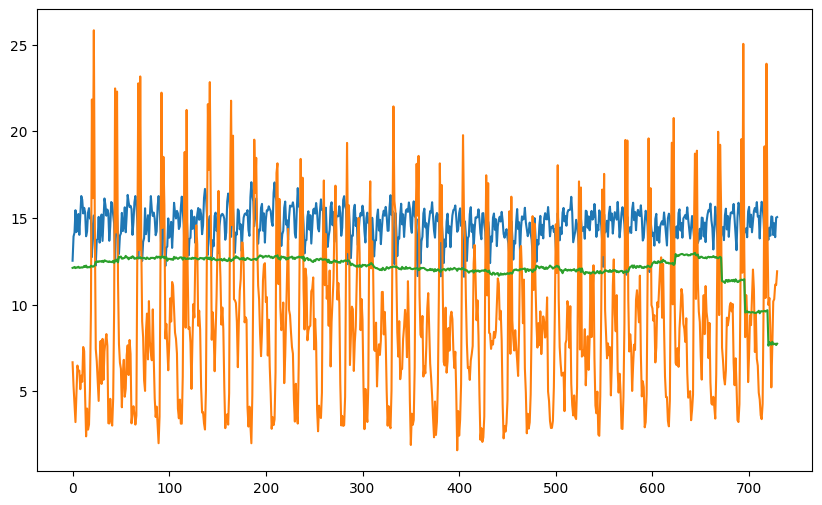

In [217]:
i = 656

plt.figure(figsize=(10,6))
plt.plot(scaled_samples[i,:])
plt.show()

In [285]:
means = np.mean(scaled_samples[:,:,2],axis=1)
sorted_means, sorted_i = np.sort(np.rint(means)), np.argsort(np.rint(means))

for i in range(len(sorted_i)):
    print(f'{sorted_i[i]}: {sorted_means[i]}')

259: -2.0
824: -1.0
272: -0.0
714: 0.0
52: -0.0
956: 0.0
276: 1.0
605: 1.0
600: 1.0
645: 1.0
23: 1.0
926: 1.0
34: 1.0
554: 1.0
221: 1.0
523: 1.0
584: 1.0
654: 1.0
237: 1.0
415: 1.0
16: 1.0
282: 1.0
777: 2.0
539: 2.0
94: 2.0
766: 2.0
763: 2.0
818: 2.0
129: 2.0
558: 2.0
569: 2.0
826: 2.0
734: 2.0
683: 2.0
681: 2.0
163: 2.0
187: 2.0
869: 2.0
536: 2.0
762: 2.0
499: 2.0
545: 2.0
477: 2.0
463: 2.0
262: 2.0
985: 2.0
296: 2.0
954: 2.0
521: 2.0
448: 2.0
37: 2.0
935: 2.0
712: 3.0
705: 3.0
691: 3.0
717: 3.0
401: 3.0
719: 3.0
398: 3.0
737: 3.0
235: 3.0
385: 3.0
393: 3.0
404: 3.0
351: 3.0
347: 3.0
342: 3.0
340: 3.0
124: 3.0
123: 3.0
338: 3.0
788: 3.0
753: 3.0
334: 3.0
281: 3.0
168: 3.0
527: 3.0
232: 3.0
230: 3.0
524: 3.0
222: 3.0
111: 3.0
470: 3.0
561: 3.0
573: 3.0
579: 3.0
200: 3.0
454: 3.0
194: 3.0
603: 3.0
433: 3.0
422: 3.0
610: 3.0
619: 3.0
632: 3.0
173: 3.0
420: 3.0
238: 3.0
661: 3.0
414: 3.0
800: 3.0
161: 3.0
54: 3.0
942: 3.0
76: 3.0
90: 3.0
89: 3.0
974: 3.0
983: 3.0
42: 3.0
885: 3.0
886: 3.0

In [304]:
year_samples = []

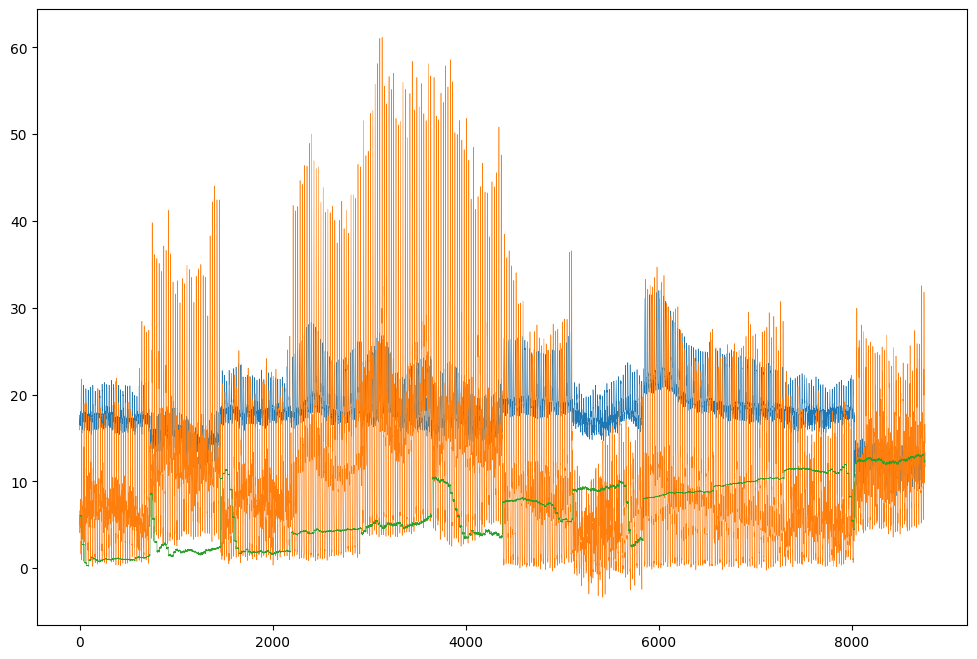

In [350]:
import random

sorted_means = {}
for i, mean in enumerate(np.rint(means)):
    if mean not in sorted_means:
        sorted_means[mean] = []
    sorted_means[mean].append(i)

target_means = np.arange(1,13)

selected_samples = []
for target in target_means:
    #samples_in_month = sorted_means[target]
    #print(target, len(samples_in_month))

    selected_sample = random.choice(sorted_means[target])
    selected_samples.append(scaled_samples[selected_sample])

plt.figure(figsize=(12,8))
plt.plot(np.concatenate(selected_samples, axis=0), linewidth=0.4)

In [351]:
year_samples.append(np.concatenate(selected_samples, axis=0))
print(len(year_samples))

10


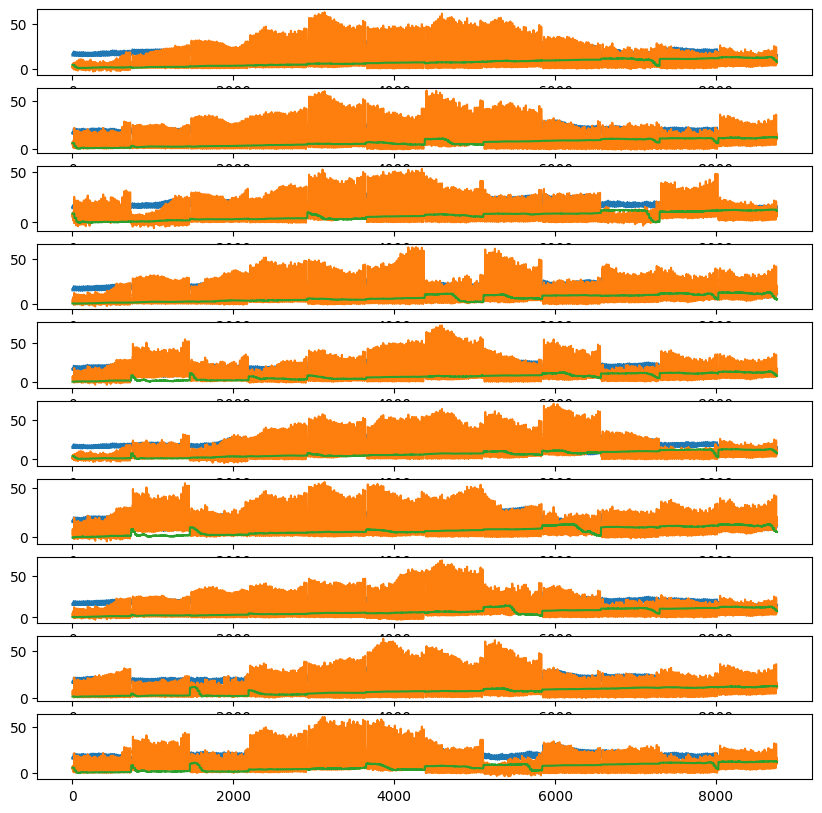

In [354]:
fig, ax = plt.subplots(10,1,figsize=(10,10))
for i in range(10):
    ax[i].plot(year_samples[i])

plt.show()